# Do visualizations of Results
Cells are independent vizualiations of figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder
import pandas as pd
from scipy.stats import binned_statistic  # For Binning

import matplotlib.cm as cm
import matplotlib.colorbar as clb
from matplotlib import gridspec

import socket
import os as os
import sys as sys
import multiprocessing as mp

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0402.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [2]:
def load_data(folder="../Simulated/Example0/", empirical=False, fullpost=False, viterbi=False, readcounts=True):
    """Load and return the Data from one Data Folder"""
    
    ob_stat = np.loadtxt(folder + "hap.csv", dtype="int", delimiter=",")
    
    if viterbi:
        viterbi_path = np.loadtxt(folder + "viterbi_path.csv", dtype="int", delimiter=",")
    else:
        viterbi_path = []
    
    if empirical==False:
        lats = np.loadtxt(folder + "lat.csv", dtype="int", delimiter=",")
        ref_states = np.loadtxt(folder + "refs.csv", dtype="int", delimiter=",")
        roh_df = 0
        read_counts = 0
        gmap = 0
        posterior = np.loadtxt(folder + "posterior.csv", dtype="float", delimiter=",")
        
    elif empirical:
        lats = 0
        roh_df  = pd.read_csv(folder + "roh.csv", delimiter=",")
        if readcounts==True:
            read_counts = np.loadtxt(folder + "readcounts.csv", delimiter=",")
        else:
            read_counts= 0
            
        gmap = np.loadtxt(folder + "map.csv", dtype="float", delimiter=",")
        
        if fullpost==True:
            posterior = np.loadtxt(folder + "posterior.csv", dtype="float", delimiter=",")  # For Plot of all Posteriors   
        else:
            posterior = np.loadtxt(folder + "posterior0.csv", dtype="float", delimiter=",")
            
        ref_states = np.zeros(np.shape(posterior)) # Just some Filler for the Moment
        
    else:
        raise RuntimeError("WTF DUDE")

    print(f"Successfully loaded Data from: {folder}")
    return (ref_states, ob_stat, lats, viterbi_path, 
            posterior, roh_df, read_counts, gmap)

### Some more Helper Functions
def process_read_counts(read_counts, m=1):
    """Return Readcount that have at least m reads for both Ref and Alt"""
    hets = (read_counts[0,:]>=m) & (read_counts[1,:]>=m)
    return hets

# Plot Viterbi Paths

In [3]:
def plot_viterbi(folder = "../Simulated/Test20r/", save=True, empirical=False):
    """Plot Viterbi Path of Haplotype copying"""
    ref_states, ob_stat, lats, viterbi_path, _, _, _, _ = load_data(folder=folder, empirical=empirical, fullpost=True, viterbi=True)
    ###########################
    ###########################

    fs = 16

    plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
    gs.update(hspace=0.3) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one

    ax.imshow(ref_states, cmap='Greys',  aspect='auto')
    if empirical == False:
        ax.plot(lats[:]-1.5, linewidth=2, color="yellow", label="Copying State") # Plot upper Boarder
        ax.plot(lats[:]-0.5, linewidth=2, color="yellow") # Plot lower boarder

     #   ax.plot(lats[1,:]-1.5, linewidth=2, color="red") # Plot upper Boarder
     #   ax.plot(lats[1,:]-0.5, linewidth=2, color="red") # Plot lower boarder

    ax.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")

    ax.set_ylabel("Ref. Hapotype",fontsize=fs)
    #ax.axhline(-.3)
    ax.set_xticks([])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=fs) # Do the Legend

    # Do the Reference SNP:
    ax1.imshow(ob_stat, cmap='Greys',  aspect='auto')
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_yticks([])
    ax1.set_ylabel("Copy")
    
    ax.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")
    
    if save==True:
        plt.savefig(folder + "viterbi_path.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

In [15]:
#plot_viterbi(folder = "../Simulated/Test20r/", empirical=False, save=False)
plot_viterbi(folder = "../Empirical/AncSards/MA89_1000G_ROH/chr4/", empirical=True, save=False)

# Plot Posterior along Chromosomes

In [3]:
def plot_posterior(folder = "../Simulated/Test20r/", save=True, empirical=False):
    """Plot Viterbi Path of Haplotype copying.
    save: Whether to save the results.
    empirical: If true, do not load and plot latent states"""
    ref_states, ob_stat, lats, viterbi_path,  \
            posterior, roh_df, read_counts, gmap = load_data(folder, empirical, fullpost=True)
    
    #if empirical == True:
    #    ref_states = np.array([ref_states[i,:] != ref_states[0,:] for i in range(len(ref_states))])  # Polarize Markers
        
    ###########################
    ###########################
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(-8, 0)

    fs = 16

    plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(4, 1, height_ratios=[10, 1, 10, 1])
    gs.update(hspace=0.2) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one
    ax2 = plt.subplot(gs[2]) # The likelihood subplot
    ax3 = plt.subplot(gs[3])

    ax.imshow(ref_states, cmap='Greys',  aspect='auto')
    if empirical == False:
        ax.plot(lats[:] - 1.5, linewidth=1.5, color="yellow", label="Latent State1") # Plot upper Boarder
        ax.plot(lats[:] - 0.5, linewidth=1.5, color="yellow") # Plot lower boarder
        ax.plot(lats[:] - 1.5, linewidth=1.5, color="red", label="Latent State2") # Plot upper Boarder
        ax.plot(lats[:] - 0.5, linewidth=1.5, color="red") # Plot lower boarder

    ax.set_ylabel("Ref. Hapotype",fontsize=fs)
    #ax.axhline(-.3)
    ax.set_xticks([])

    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=fs) # Do the Legend

    # Do the Reference SNP
    ax1.imshow(ob_stat, cmap='Greys',  aspect='auto')
    ax1.set_yticks([])
    ax1.set_ylabel("Copy")
    ax1.set_xlabel("SNP", fontsize=fs, labelpad=-10)
    
    # Do the Viridis CMAP:
    
    # Do the Posterior:
    ax2.imshow(posterior, aspect='auto', cmap=cmap, norm=norm)
    
    if empirical == False:
        ax2.plot(lats[:] - 0.5, linewidth=1.5, color="yellow", label="Latent State1") # Plot upper Boarder
        ax2.plot(lats[:] + 0.5, linewidth=1.5, color="yellow") # Plot lower boarder
        #ax2.plot(lats[1,:] - 0.5, linewidth=1.5, color="red", label="Latent State2") # Plot upper Boarder
        #ax2.plot(lats[1,:] + 0.5, linewidth=1.5, color="red") # Plot lower boarder
        #ax2.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")x2.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")
        ax2.set_ylabel("Posterior of States", fontsize=fs)
    
    ### Color Map
    cb1 = clb.ColorbarBase(ax3, cmap=cmap,
                            norm=norm,   # For the /1e3 format
                            orientation='horizontal')
    
    ax3.set_xlabel("Log Likelihood", fontsize=fs)
    #cb1.ax.tick_params(axis='y', direction='in')
    #cb1.ax.yaxis.tick_left()
    
    if save==True:
        plt.savefig(folder + "posterior.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    ###########################################
    ### Plot the Posterior for State 0
    
    plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10])
    gs.update(hspace=0.1) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one
    
    #print(lats==0)
    #ax.imshow([lats[0,:]==lats[1,:]],  cmap='Greys_r',  aspect='auto')
    homo = (ob_stat[0,:]==ob_stat[1,:])
    ax.imshow([homo, homo], cmap='Greys_r',  aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Homozygosity", fontsize=fs)
    
    ax1.plot(np.exp(posterior[0,:]), linewidth=4, color="maroon", label="State 0")
    #ax1.legend(fontsize=fs, loc="lower center")
    ax1.set_xlim(0, np.shape(posterior)[1])
    ax1.set_ylabel("Posterior Probability", fontsize=fs)
    ax1.set_xlabel("SNP", fontsize=fs)
    
    if save==True:
        plt.savefig(folder + "posterior_HW.pdf", bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    
    
def plot_posterior_cm(folder = "../Simulated/Test20r/", savepath="", empirical=True, 
                      plot=True, cm_lim=[], m=1, groundtruth=False, readcount=False, 
                     plot_hets=True, plot_calls=True, plot_post=True,
                      figsize=(14,4), title="", post_c="maroon", het_c="blue"):
    """Plot Viterbi Path of Haplotype copying.
    save: Whether to save the results.
    empirical: If true, do not load and plot latent states
    cm_lim: What Area to Zoom In (CentiMorgan)
    m: How many reads for ref and alt
    groundtruth: Whether to plot Ground Truth (saved as csv)
    plot_hets: Whether to plot Heterozygote Markers
    plot_calls: Whether to plot Calls
    plot_post: Whether to plot posterior"""
    
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(-8, 0)

    fs = 14  
    lw = 6   # Linewidth for ROH
    
    _, ob_stat,_,_,posterior, roh_df, read_counts, gmap = load_data(folder, empirical, readcounts=readcount)
    assert(len(gmap)==np.shape(ob_stat)[1])
        
    ###########################
    ###########################
    # Do the Plot
    
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 8])
    gs.update(hspace=0.3) # set the spacing between axes. 

    #ax = plt.subplot(gs[0]) # The upper subplot
    ax1 = plt.subplot(gs[1]) # The lower subplot
    
    ### Depict Readcounts or GT Heteroyzgotes
    if readcount==False:
        het = (ob_stat[0,:] != ob_stat[1,:])
    elif readcount==True:
        het = process_read_counts(read_counts, m=m)
    else:
        raise RuntimeError("Invalid Mode!")
        
    #ax.plot(gmap*100, het, "bo", ms=2, alpha=0.3)
    #ax.set_ylabel("Het", fontsize=fs)
    #ax.set_title("Hetorzygosity", fontsize=fs)
    if plot_post:
        ax1.plot(gmap*100, np.exp(posterior), linewidth=2, color=post_c, label="State 0", zorder=1)
        ax1.set_ylabel("Post. Probability", fontsize=fs, color=post_c)
    
    if plot_calls:
        plt.hlines(y=[1.2]*len(roh_df), xmin=100 * roh_df["StartM"], xmax= 100 * roh_df["EndM"], 
                        colors="blue", linewidth=lw)
    
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_xlabel("CentiMorgan")
    
    if len(cm_lim)==2:
        ax1.set_xlim(cm_lim)
        
    ### Load & Plot Groundtruth (if given):
    if groundtruth:
        path = folder + "roh_gt.csv"
        dft = pd.read_csv(path, sep="\t")
        ### Plot them
        plt.hlines(y=[1.12]*len(dft), xmin=100 * dft["ROH_Begin"], xmax=100 * dft["ROH_End"], 
                    colors="green", linewidth=lw)
    
    ### Plot Heterozygotes, if plot_hets
    if plot_hets:
        ax1.plot(gmap*100, (het * 1.1 - 0.05), "o", ms=1, alpha=0.3, zorder=0, color=het_c)
        ax2 = ax1.twinx()
        ax2.set_ylim(ax1.get_ylim())
        ax2.set_yticks(np.array([1,0]) * 1.1 - 0.05)
        ax2.set_yticklabels([])
        ax1.set_yticklabels([])
        ax2.set_ylabel(f"$\geq/\geq$ {m} Ref/Alt Reads", fontsize=fs*0.7, color=het_c)
        
    if len(title)>0:
        plt.title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to: {savepath}")
        #plt.savefig(folder + "posterior_cm.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)
    
    if plot==True:
        plt.show()

In [7]:
#process_read_counts(read_counts, m=1)
#plot_posterior(folder = "../Simulated/Test20r/", save=True)
#plot_posterior(folder = "../Empirical/1kEUR_ROH9/", save=True, empirical=True)
#plot_posterior(folder = "../Empirical/Sard100_0-10kROH6/", save=True, empirical=True)
#plot_posterior(folder = "./Empirical/AncSards/MA89_1000G_ROH/chr3/", save=True, empirical=True)

### Do the Empirical Plot (with Linkage Maps)

Successfully loaded Data from: ./Empirical/HO/Makrani_1/chr6/


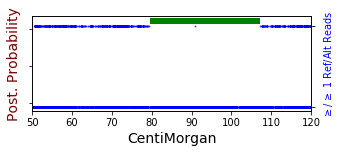

In [22]:
#plot_posterior_cm(folder = "../Empirical/AncSards/MA89_1000G_ROH_v1/chr5/", save=True, 
#                  empirical=True, m=2, cm_lim=[])  #d05e

#plot_posterior_cm(folder = "./Empirical/SEC002_1000G_ROH/chr15/", save=True, 
#                  empirical=True, m=1, cm_lim=[])  #d05e

plot_posterior_cm(folder = "./Empirical/HO/Makrani_1/chr6/", savepath="./figures/poster_probgen19/markani1_roh.png",
                  empirical=True, cm_lim=[50, 120], readcount=False, plot_post=False, figsize=(5,3))  # MA89 Chr8

#plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm/output/iid6/chr3/ROHin100/", figsize=(6,4),
#                  empirical=True, m=1, cm_lim=[100,115], groundtruth = True, readcount=False, savepath="./figures/talk_harvard/TSI5_ch3_6cm.png",
#                 plot_post=True)

#plot_posterior_cm(folder = "./Empirical/1240k/ORC008/chr1/e01/", save=False, 
#                  empirical=True, m=1, cm_lim=[50, 100])  # MA89 Chr8

### Plot Simulated Individual

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/lambda_rc0.2/ch3_8cm/output/iid0/chr3/


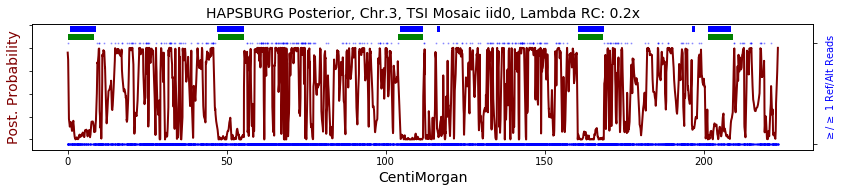

In [19]:
### from diploid mode
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc0.2/ch3_8cm/output/iid0/chr3/", 
                  empirical=True, m=1, cm_lim=[], groundtruth = True, readcount = True, 
                  plot_calls=True, title="HAPSBURG Posterior, Chr.3, TSI Mosaic iid0, Lambda RC: 0.2x") 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/
here


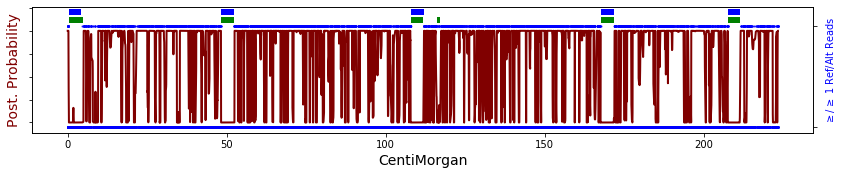

In [40]:
### From haploid mode
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/", 
                  empirical=True, m=1, cm_lim=[], groundtruth = True, readcount = False) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_4cm/output/iid0/chr3/test/


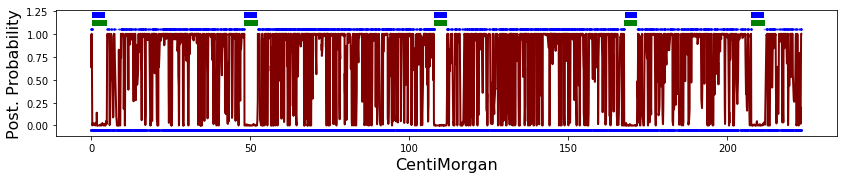

In [9]:
### From rc mode
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_4cm/output/iid0/chr3/test/", 
                  empirical=True, m=1, cm_lim=[], groundtruth = True, readcount = False)

Successfully loaded Data from: ./Simulated/1000G_Mosaic/YRI/ch3_2cm/output/iid20/chr3/allRef/


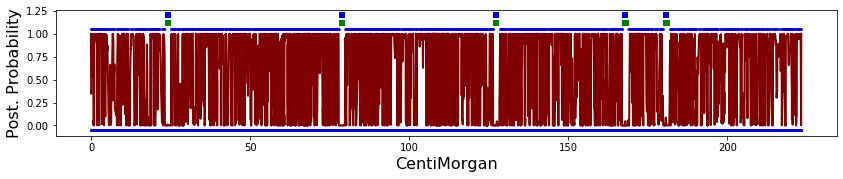

In [56]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/YRI/ch3_2cm/output/iid20/chr3/allRef/", 
                  empirical=True, m=1, cm_lim=[], groundtruth = True, readcount = False) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_6cm/output/iid6/chr3/ROHin100/


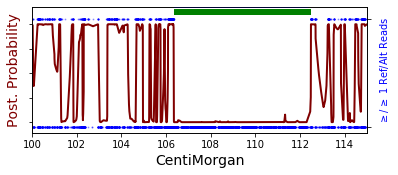

In [14]:
#plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc3.0/ch3_10cm/output/iid1/chr3/e01/", save=False, 
#                  empirical=True, m=2, cm_lim=[], groundtruth = True, readcount=True) 

plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm/output/iid6/chr3/ROHin100/", figsize=(6,4),
                  empirical=True, m=1, cm_lim=[100,115], groundtruth = True, readcount=False, savepath="./figures/talk_harvard/TSI5_ch3_6cm.png",
                 plot_post=True)

# Compare handpicked and ML parameters

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/


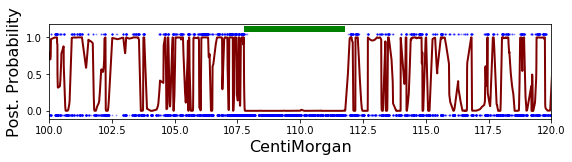

In [66]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/", savepath="./figures/talk_harvard/ROHin100ch3iid0_gt.pdf", 
                  empirical=True, m=2, cm_lim=[100, 120], groundtruth = False, plot_hets = True, plot_calls=True, 
                 figsize=(9, 3)) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/CHB/lambda_rc0.5/ch3_4cm/output/iid0/chr3/e01/


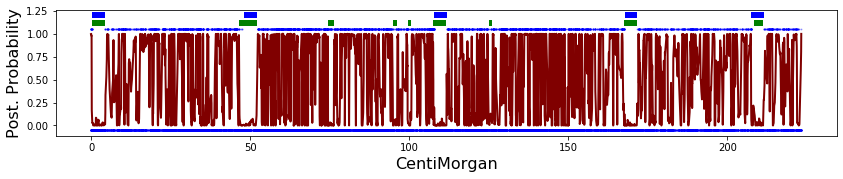

In [8]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/CHB/lambda_rc0.5/ch3_4cm/output/iid0/chr3/e01/", savepath="", 
                  empirical=True, m=2, cm_lim=[], groundtruth = True)

### Compare All Reference with European Reference only

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/allRef300/
here


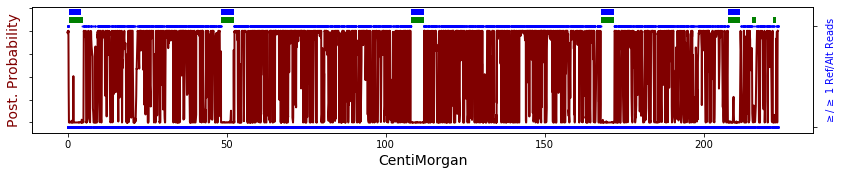

In [37]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/allRef300/", 
                  empirical=True, cm_lim=[], groundtruth = True) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/


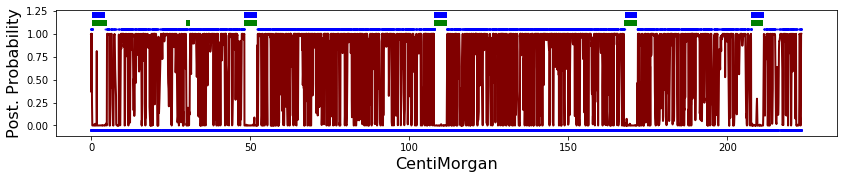

In [5]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/", 
                  empirical=True, cm_lim=[], groundtruth = True) 

### Plot Empirical Individuals

Successfully loaded Data from: ./Empirical/Eigenstrat/Freilich20/ZEM05/chr13/


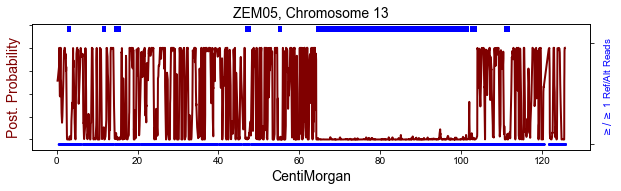

In [11]:
plot_posterior_cm(folder = "./Empirical/Eigenstrat/Freilich20/ZEM05/chr13/", savepath="", 
                  empirical=True, m=1, cm_lim=[], groundtruth = False, 
                  readcount=False, figsize=(10,4), title="ZEM05, Chromosome 13"
                  )   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/MarcusAncs/VIL006/chr1/e01/


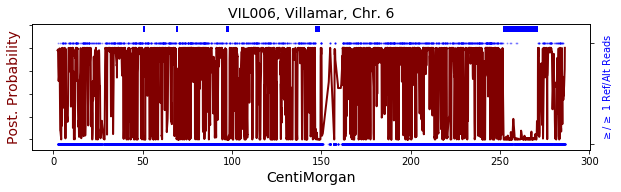

In [23]:
plot_posterior_cm(folder = "./Empirical/1240k/MarcusAncs/VIL006/chr1/e01/", savepath="", 
                  empirical=True, m=1, cm_lim=[], groundtruth = False, readcount=True, figsize=(10,4),
                  title="VIL006, Villamar, Chr. 6")   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/MarcusAncs/I9006/chr7/e01/


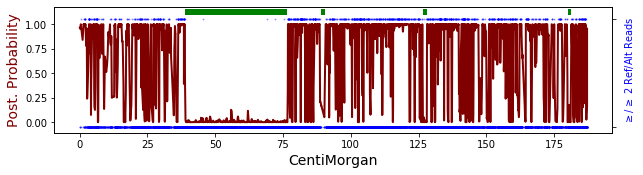

In [50]:
### Run Harald's Machine
plot_posterior_cm(folder = "./Empirical/1240k/MarcusAncs/I9006/chr7/e01/", savepath="./figures/talk_harvard/MA89chr4m1.pdf", 
                  empirical=True, m=2, cm_lim=[], groundtruth = False, readcount=True, figsize=(10,4),
                 )   # ./Empirical/1240k/SEC002/chr20/e01/

### Plot ancients from Olalde 19

Successfully loaded Data from: ./Empirical/Eigenstrat/Olalde19/I7550/chr6/


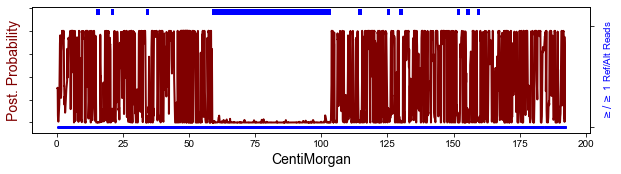

In [202]:
plot_posterior_cm(folder = "./Empirical/Eigenstrat/Olalde19/I7550/chr6/", savepath="", 
                  empirical=True, m=1, cm_lim=[], groundtruth = False, readcount=False, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

## Compare Eigenstrat Calling with RC calling
Paper: Ust Ishim Chr. 3 0 to 100 cM with (10,4) figsize

Successfully loaded Data from: ./Empirical/Eigenstrat/Reichall/Ust_Ishim_published.DG/chr3/
Saved figure to: ./figures_test/ust_ishim_40.pdf


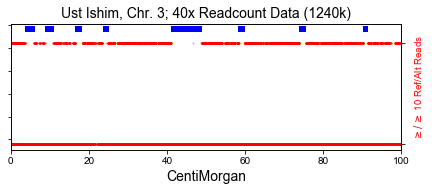

In [33]:
plot_posterior_cm(folder = "./Empirical/Eigenstrat/Reichall/Ust_Ishim_published.DG/chr3/", savepath="./figures_test/ust_ishim_40.pdf", 
                  empirical=True, m=10, cm_lim=[0,100], groundtruth = False, readcount=False, figsize=(7,4),
                  plot_post=False, het_c="red", title="Ust Ishim, Chr. 3; 40x Readcount Data (1240k)")   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim/1.0000/chr3/
Saved figure to: ./figures/manuscript/supplement/downsampling_sa/ust_ishim_40rc.png


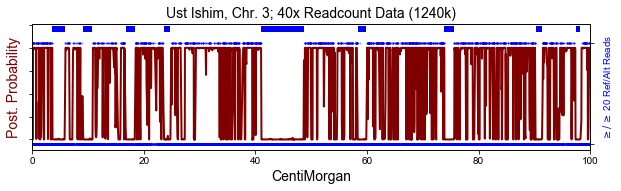

In [38]:
plot_posterior_cm(folder = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim/1.0000/chr3/", 
                  savepath="./figures/manuscript/supplement/downsampling_sa/ust_ishim_40rc.png", 
                  title="Ust Ishim, Chr. 3; 40x Readcount Data (1240k)",
                  empirical=True, m=20, cm_lim=[0,100], groundtruth = False, readcount=True, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim/0.0162/chr3/
Saved figure to: ./figures/manuscript/supplement/downsampling_sa/ust_ishim_065rc.png


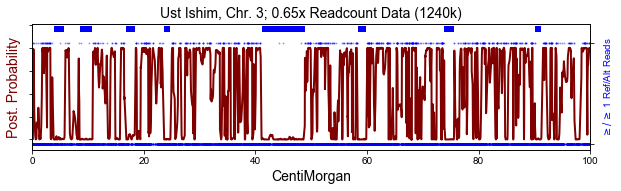

In [39]:
plot_posterior_cm(folder = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim/0.0162/chr3/", 
                  savepath="./figures/manuscript/supplement/downsampling_sa/ust_ishim_065rc.png", 
                  title="Ust Ishim, Chr. 3; 0.65x Readcount Data (1240k)",
                  empirical=True, m=1, cm_lim=[0,50], groundtruth = False, readcount=True, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim_ph/0.5000/chr3/
Saved figure to: ./figures/manuscript/supplement/downsampling_sa/ust_ishim_05ph.png


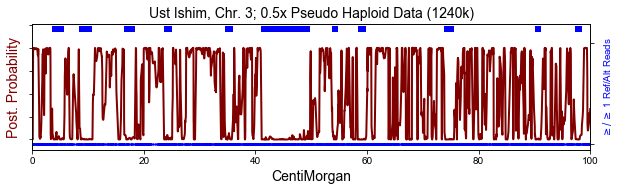

In [40]:
plot_posterior_cm(folder = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim_ph/0.5000/chr3/", 
                  savepath="./figures/manuscript/supplement/downsampling_sa/ust_ishim_05ph.png", 
                  title="Ust Ishim, Chr. 3; 0.5x Pseudo Haploid Data (1240k)",
                  empirical=True, m=1, cm_lim=[0,100], groundtruth = False, readcount=False, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim_ph/1.0000/chr3/
Saved figure to: ./figures/manuscript/supplement/downsampling_sa/ust_ishim_10ph.png


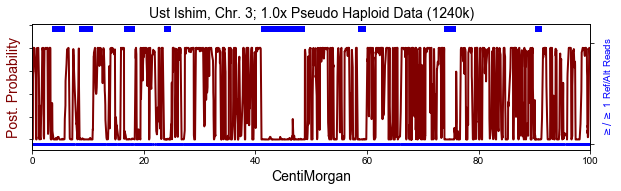

In [41]:
plot_posterior_cm(folder = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim_ph/1.0000/chr3/", 
                  savepath="./figures/manuscript/supplement/downsampling_sa/ust_ishim_10ph.png", 
                  title="Ust Ishim, Chr. 3; 1.0x Pseudo Haploid Data (1240k)",
                  empirical=True, m=1, cm_lim=[0,100], groundtruth = False, readcount=False, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/Eigenstrat/Reichall/Stuttgart_published.DG/chr2/


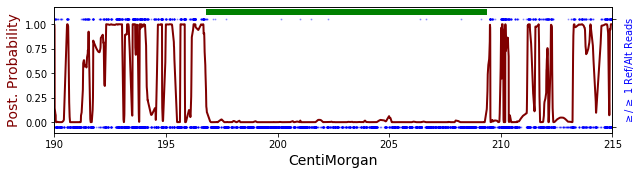

In [5]:
plot_posterior_cm(folder = "./Empirical/Eigenstrat/Reichall/Stuttgart_published.DG/chr2/", savepath="", 
                  empirical=True, m=1, cm_lim=[190, 215], groundtruth = False, readcount=False, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/Eigenstrat/Reichall/IPY10.SG/chr7/


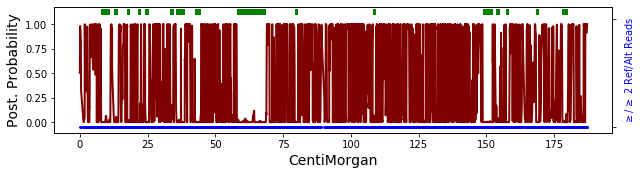

In [112]:
plot_posterior_cm(folder = "./Empirical/Eigenstrat/Reichall/IPY10.SG/chr7/", savepath="", 
                  empirical=True, m=2, cm_lim=[], groundtruth = False, readcount=False, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/SA_Readcounts/895/chr11/


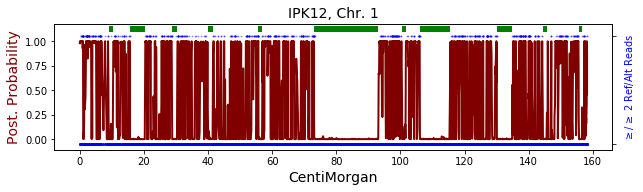

In [4]:
plot_posterior_cm(folder = "./Empirical/1240k/SA_Readcounts/895/chr11/", savepath="", title="IPK12, Chr. 1", 
                  empirical=True, m=2, cm_lim=[], groundtruth = False, readcount=True, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/Eigenstrat/Reichall/Yaghan895.SG/chr11/


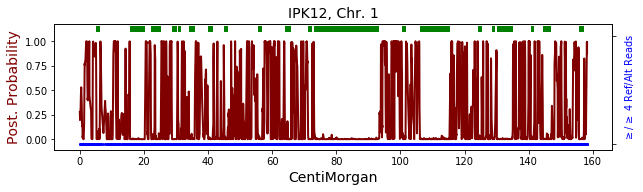

In [25]:
plot_posterior_cm(folder = "./Empirical/Eigenstrat/Reichall/Yaghan895.SG/chr11/", savepath="", title="IPK12, Chr. 1", 
                  empirical=True, m=4, cm_lim=[], groundtruth = False, readcount=False, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

### Comparison South America RC vrs Pseudohaploid

Successfully loaded Data from: ./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_ph/0.5000/chr3/


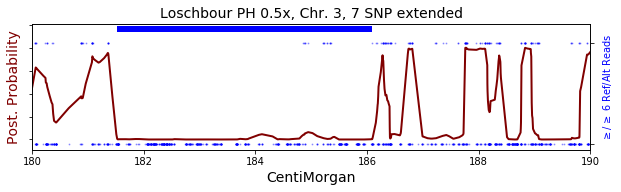

In [32]:
plot_posterior_cm(folder = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_ph/0.5000/chr3/", savepath="", 
                  empirical=True, m=6, cm_lim=[180,190], groundtruth = False, readcount=True, figsize=(10,4), title="Loschbour PH 0.5x, Chr. 3, 7 SNP extended")   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/SA_Readcounts/Downsample_Loschbour/0.0278/chr2/


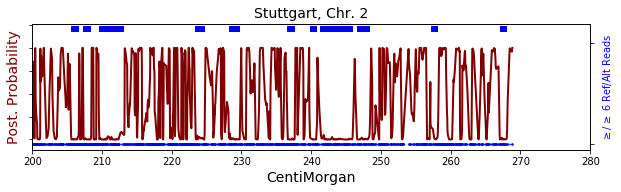

In [13]:
plot_posterior_cm(folder = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour/0.0278/chr2/", savepath="", 
                  empirical=True, m=6, cm_lim=[200,280], groundtruth = False, readcount=True, figsize=(10,4), title="Stuttgart, Chr. 2")   # ./Empirical/1240k/SEC002/chr20/e01/

##### Plot single Eigenstrat Ancient (interchangable):

Successfully loaded Data from: ./Empirical/1240k/MarcusAncs/I5244/chr14/e01/


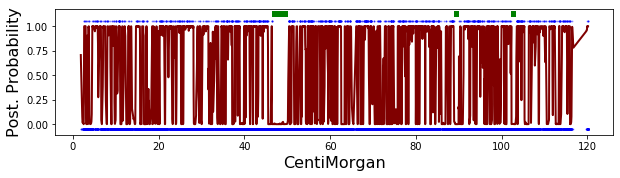

In [46]:
plot_posterior_cm(folder = "./Empirical/1240k/MarcusAncs/I5244/chr14/e01/", savepath="", 
                  empirical=True, m=2, cm_lim=[], groundtruth = False, readcount=True, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

### Antonio 19 Romans

Successfully loaded Data from: ./Empirical/1240k/Antonio/RMPR-121/chr13/
Saved figure to: ./figures_test/RMPR-121_posterior_chr13.pdf


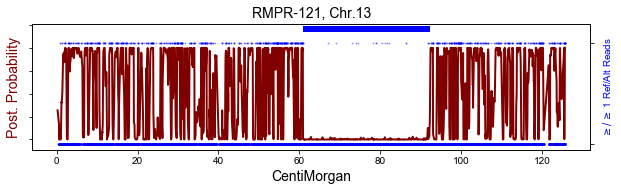

In [45]:
plot_posterior_cm(folder = "./Empirical/1240k/Antonio/RMPR-121/chr13/", title="RMPR-121, Chr.13",
                  empirical=True, m=1, cm_lim=[], groundtruth = False, readcount=True, figsize=(10,4),
                  savepath="./figures_test/RMPR-121_posterior_chr13.pdf") # ./figures/antonio_share/RMPR-121_posterior_chr13.pdf

Successfully loaded Data from: ./Empirical/1240k/Antonio/RMPR-1286/chr21/


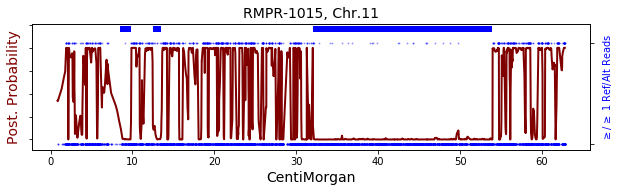

In [88]:
plot_posterior_cm(folder = "./Empirical/1240k/Antonio/RMPR-1286/chr21/", savepath="", title="RMPR-1015, Chr.11",
                  empirical=True, m=1, cm_lim=[], groundtruth = False, readcount=True, figsize=(10,4))

Successfully loaded Data from: ./Empirical/Eigenstrat/Reichall/MA577.SG/chr1/


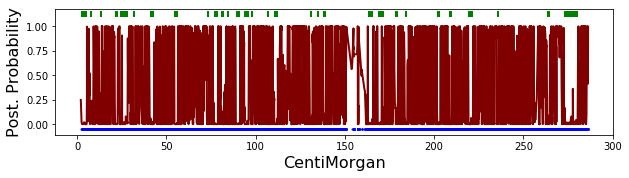

In [7]:
plot_posterior_cm(folder = "./Empirical/Eigenstrat/Reichall/MA577.SG/chr1/", savepath="", 
                  empirical=True, m=2, cm_lim=[], groundtruth = False, readcount=False, figsize=(10,4))   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/Ogl_5/chr7/e01/


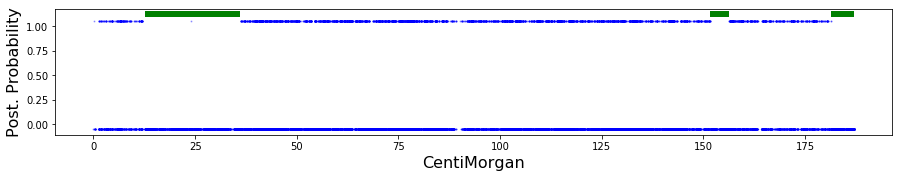

In [7]:
plot_posterior_cm(folder = "./Empirical/1240k/Ogl_5/chr7/e01/", figsize=(15,4),
                  empirical=True, m=1, cm_lim=[], groundtruth = False, readcount=False, savepath="./figures/talk_harvard/ogl5_chr7.png",
                 plot_post=False)

Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr11/e01/


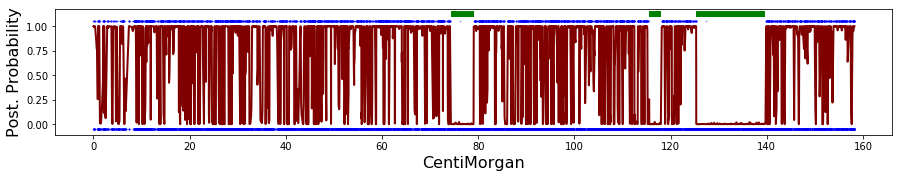

In [69]:
plot_posterior_cm(folder = "./Empirical/1240k/HO/Turkish_3/chr11/e01/", figsize=(15,4),
                  empirical=True, m=1, cm_lim=[], groundtruth = False, readcount=False, savepath="",
                 plot_post=True)

# Compare handpicked and ML (only ROH385)

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/baseline/


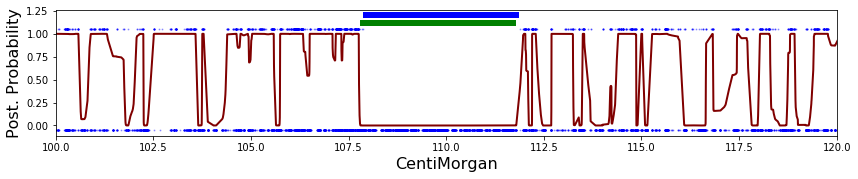

In [76]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/baseline/", save=False, 
                  empirical=True, m=2, cm_lim=[100,120], groundtruth = True) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/maxll/


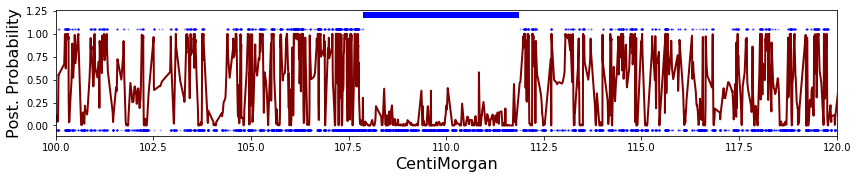

In [75]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/maxll/", save=False, 
                  empirical=True, m=2, cm_lim=[100,120], groundtruth = True)

# Plot smoothed Prior (and real prior)

In [9]:
def smooth_posterior(posterior, gmap, step=0.1):
    """Smooths the Posterior.
    gmap: In cM
    Step: In cM"""
    min_cm = np.min(gmap)
    max_cm = np.max(gmap)
    bins = np.arange(min_cm, max_cm, step)  # Create the binning
    
    bin_means, bin_edges, _ = binned_statistic(gmap, posterior, statistic="mean", bins = bins)
    
    return bin_means, bin_edges

def sliding_window_posterior(posterior, gmap, step=0.1):
    """Do a Sliding Window Approach"""
    
    dist = np.abs(gmap[:,None] - gmap) < step
    snps_reach = np.sum(dist, axis=1)  # How many SNPs are in reach for every SNP
    posterior_sw = np.dot(dist, posterior) / snps_reach
    
    return posterior_sw
    

def plot_posterior_smooth_cm(folder = "../Simulated/Test20r/", save=False, empirical=True, 
                      plot=True, cm_lim=[], m=1, groundtruth=False, mosaic=False, bin_width=100, smooth_step=0.1):
    """Plot Viterbi Path of Haplotype copying.
    save: Whether to save the results.
    empirical: If true, do not load and plot latent states
    cm_lim: What Area to Zoom In (CentiMorgan)
    m: How many reads for ref and alt
    groundtruth: Whether to plot Ground Truth (saved as csv)"""
    
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(-8, 0)

    fs = 16
    lw = 6 # Linewidth for ROH
    
    _, ob_stat,_,_,posterior, roh_df, read_counts, gmap = load_data(folder, empirical)
    assert(len(gmap)==np.shape(ob_stat)[1])
    
    ### Smooth the Posterior
    posterior_sw = sliding_window_posterior(np.exp(posterior), gmap*100, step=smooth_step)
    
    ###########################
    ###########################
    # Do the Plot
    
    plt.figure(figsize=(14,3))    
    ax1 = plt.gca()
    
    het = (ob_stat[0,:]!=ob_stat[1,:])
    if empirical==True:  
        het = process_read_counts(read_counts, m=m)       
    if mosaic == True:
        het = (ob_stat[0,:] != ob_stat[1,:])
    
    ax1.plot(gmap*100, np.exp(posterior), linewidth=2, color="gray", label="State 0", zorder=1)
    ax1.plot(gmap*100, posterior_sw, linewidth=3, color="red", zorder = 2) # Plot the sliding window posterior   
    ax1.plot(gmap*100, (het * 1.1 - 0.05), "bo", ms=1, alpha=0.3, zorder=0)  # Plot Heterozygosity
    
    #bin_means, bin_edges = smooth_posterior(np.exp(posterior), gmap*100, step=smooth_step)
    #plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='red', lw=3, zorder=2)
    
    plt.hlines(y=[1.12]*len(roh_df), xmin=100 * roh_df["StartM"], xmax= 100 * roh_df["EndM"], 
                    colors="green", linewidth=lw)
    
    ax1.set_ylabel("Post. Probability", fontsize=fs)
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_xlabel("CentiMorgan")
    
    if len(cm_lim)==2:  ### If correct format Limit is given
        ax1.set_xlim(cm_lim)    
        
    ### Load & Plot Groundtruth (if given):
    if groundtruth==True:
        path = folder + "roh_gt.csv"
        dft = pd.read_csv(path, sep="\t")
        
        ### Plot them
        plt.hlines(y=[1.2]*len(dft), xmin=100 * dft["ROH_Begin"], xmax= 100 * dft["ROH_End"], 
                    colors="blue", linewidth=lw)
        
    if save==True:
        plt.savefig(folder + "posterior_cm.pdf", bbox_inches = 'tight', pad_inches = 0)
        plt.savefig(folder + "posterior_cm.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)
    
    if plot==True:
        plt.show()
        
    return posterior

In [ ]:
%%time
posterior = plot_posterior_smooth_cm(folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc3.0/ch3_10cm/output/iid1/chr3/e01/", save=False, 
                  empirical=True, cm_lim=[0,100], groundtruth = True, mosaic=True, smooth_step=0.1) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/lambda_rc3.0/ch3_10cm/output/iid1/chr3/e01/


In [ ]:
print("why oh why")

# Plot one full Individual
Plot one Individual across all Chromosomes

In [31]:
def plot_full_ROH_ind(iid, chs=[], m=1, save=False, plot=True, prefix_out ="e01/", 
                      readcounts=True, folder="./Emprical/1240k/"):
    """Plot Full ROH of a single Individual. Scan over all Chromosomes.
    m: The Level"""
    
    if len(chs)==0:
        chs = np.arange(1,23)  # Do all Chromosomes by default

    folder = folder + iid + "/"

    ### Some Parameters for the Plot
    fs_l = 14  # Font Size Labels
    fs = 10
    lw = 5     # Linewidth for ROH

    ### Create the Figure:
    plt.figure(figsize=(14, 2*len(chs)))
    gs = gridspec.GridSpec(len(chs), 1) # height_ratios=[len(chs) * 2, 8]

    gs.update(hspace=0.2) # set the spacing between axes. 
    axarr = [plt.subplot(gs[i]) for i in range(len(chs))]

    ### Fill it with Data:
    for i, ch in enumerate(chs):
        #print(f"Doing Chromosome: {ch}")
        ax = axarr[i]
        ax.set_ylabel(f"Chr: {ch}", fontsize = fs_l, rotation=270, labelpad=14)
        ax.yaxis.set_label_position("right")

        ### Do the Plotting
        # Load the data
        load_folder = folder + "chr" + str(ch) + "/" + prefix_out
        _, ob_stat, _, _, \
                posterior, roh_df, read_counts, gmap = load_data(load_folder, empirical=True)
        
        if readcounts == True:
            het = process_read_counts(read_counts, m=m)
        else:
            het = (ob_stat[0,:] != ob_stat[1,:])

        ax.plot(gmap*100, np.exp(posterior), linewidth=2, color="maroon", label="State 0", zorder=1)
        ax.plot(gmap*100, (het * 1.1 - 0.05), "bo", ms=1, alpha=0.3,zorder=0)
        ax.hlines(y=[1.15]*len(roh_df), xmin=100 * roh_df["StartM"], xmax= 100 * roh_df["EndM"], 
                        colors="green", linewidth=lw)

    ### Set the XLabel
    axarr[-1].set_xlabel("CentiMorgan", fontsize = fs_l)

    axarr[0].set_title(iid, fontsize=fs_l)
    ### Save as PDF:
    if save==True:
        #plt.savefig(folder + "all_cromsomomesROH.pdf", bbox_inches = 'tight', pad_inches = 0)
        plt.savefig(folder + "all_cromsomomesROH.png", bbox_inches = 'tight', pad_inches = 0, dpi=300) #bc why not
    if plot==True:
        plt.show()
    else: plt.close()

Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr1/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr2/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr3/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr4/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr5/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr6/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr7/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr8/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr9/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr10/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr11/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr12/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr13/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_

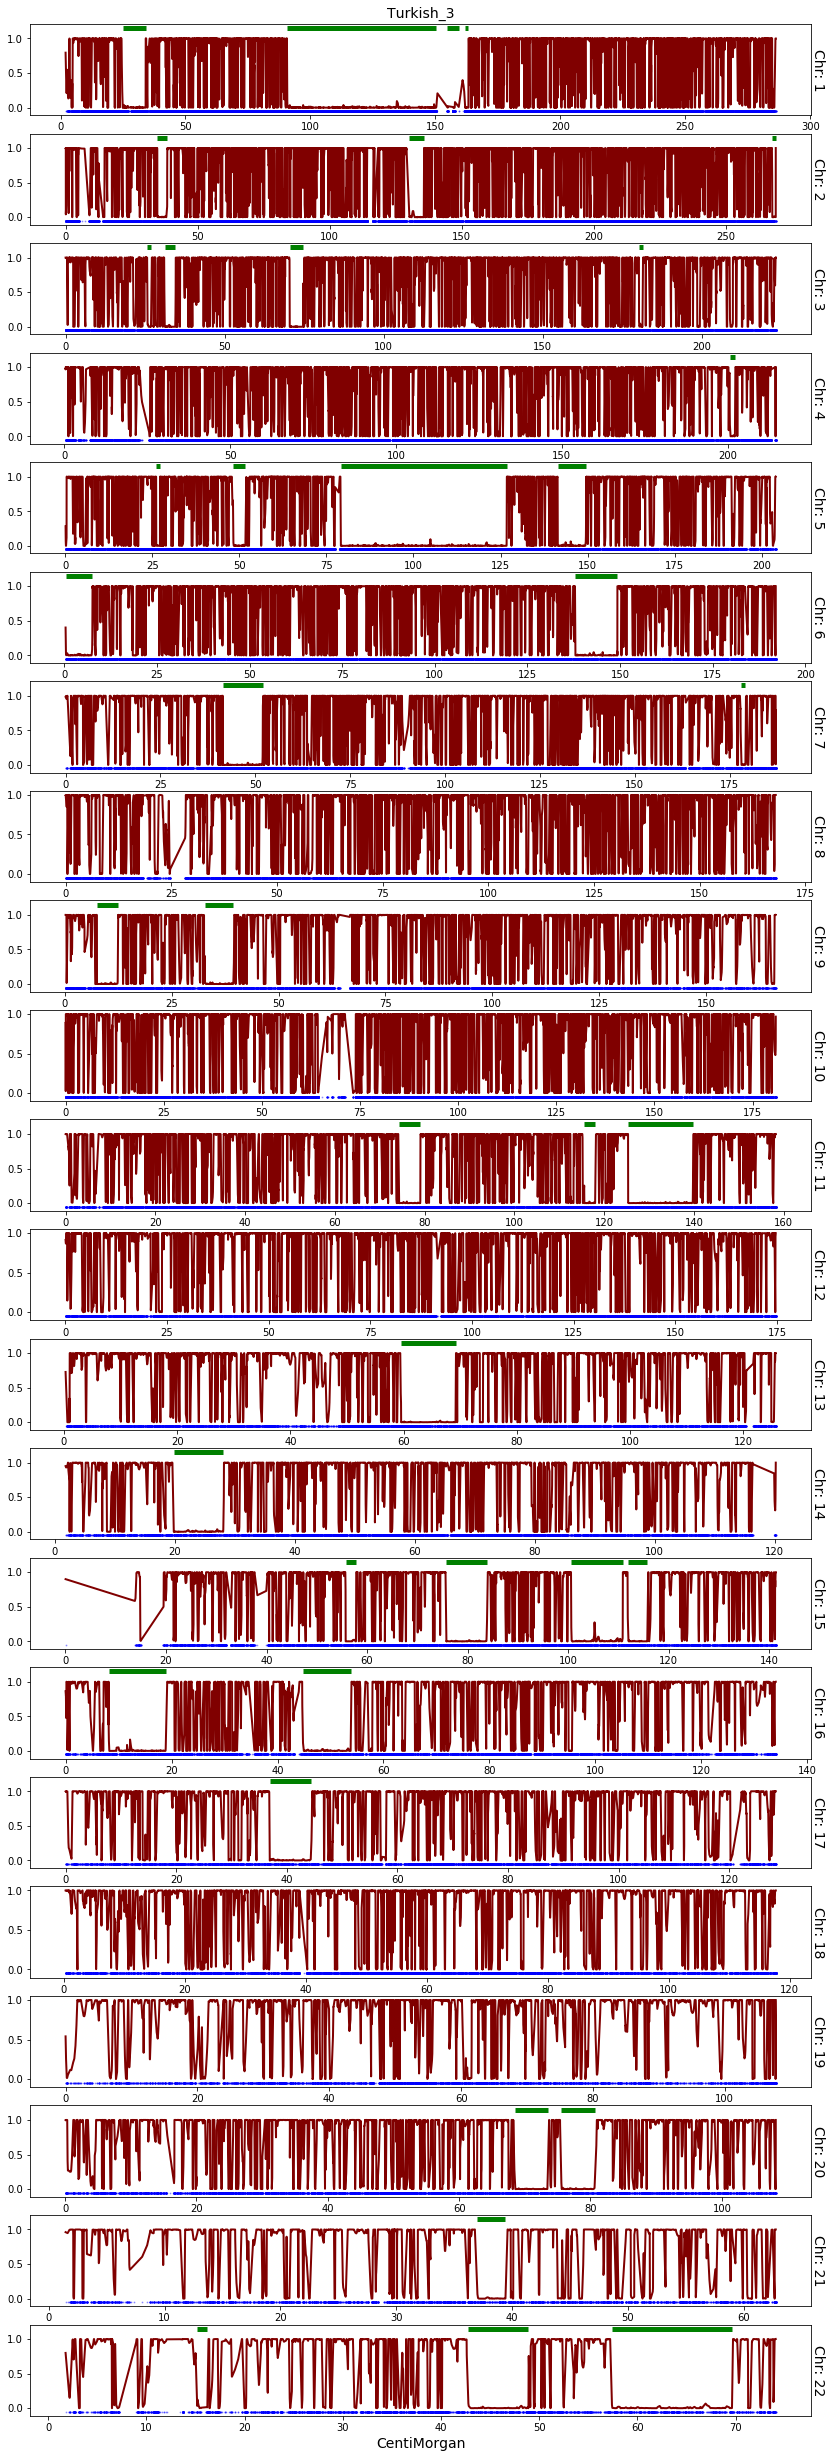

In [10]:
chs = np.arange(1,23)
plot_full_ROH_ind(iid="Turkish_3", chs=chs, m=2, readcounts=True, save=False, folder="./Empirical/1240k/HO/")   ### I2521 I3068 : HG

In [8]:
### Do all ancients Sardinian Individual
def plot_all_ancsards():
    """Make ROH Plot of all ancient Sardinians."""
    meta_path = "../../ancient-sardinia/output/meta/meta_final.csv"
    anc_ind = 1029  # Up to which individual there are ancestrals
    anc_sardind = 57  # Nr of ancient Sarinian individuals
    min_cov = 0.5

    meta_df = pd.read_csv(meta_path)  # Load the Meta File
    as_df = meta_df[:anc_sardind]
    iid_list = as_df[(as_df["mean_cov"] > min_cov)]["iid"].values
    print(f"Found n={len(iid_list)} Inds with Cov > {min_cov}")


    for iid in iid_list:
        chs = np.arange(1,23)
        plot_full_ROH_ind(iid=iid, chs=chs, m=1, save=True, plot=False)

In [ ]:
plot_all_ancsards()

# Area 51

In [45]:
t = np.loadtxt("./Empirical/Eigenstrat/Reichall/Stuttgart_published.DG/chr1/hap.csv", dtype="int", delimiter=",")

In [46]:
a = np.sum(t, axis=0)
pd.value_counts(a)

0    49421
1    22558
2    15614
dtype: int64

In [36]:
t[:,20:40]

array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

0    54292
2    26808
1     1319
dtype: int64